Develop function to interpolate a plane with griddata, LinearNDinterpolator, and matplotlib's tri.interpolator

In [1]:
import numpy as np
import scipy.optimize as opti
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

from scipy.spatial import Delaunay
import matplotlib.tri as tri
from scipy.interpolate import LinearNDInterpolator
import cPickle as pickle

In [2]:
import sys
sys.path.append('/Users/vonderlinden2/rsx_analysis/writing_to_vtk/source')
import structured_3d_vtk as struc_3d
reload(struc_3d)

<module 'structured_3d_vtk' from '/Users/vonderlinden2/rsx_analysis/writing_to_vtk/source/structured_3d_vtk.pyc'>

In [3]:
spatial_increment = 0.001
x_min, x_max = -0.028, 0.025
y_min, y_max = -0.043, 0.039
z_min, z_max = 0.249, 0.249

bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

x_coord = np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment))
y_coord = np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment))

mesh = np.meshgrid(x_coord, y_coord, indexing='ij')
grid_points = np.dstack(map(np.ravel, mesh))[0]

sizes = (np.unique(grid_points[:, 0]).size,
         np.unique(grid_points[:, 1]).size)
    
grid_swapped = np.swapaxes(grid_points, 0, 1)
grid_x = np.resize(grid_swapped[0], (sizes[0], sizes[1]))
grid_y = np.resize(grid_swapped[1], (sizes[0], sizes[1]))
grid_z0249 = np.asarray([grid_x, grid_y])

In [14]:

bx_measurements = struc_3d.read_idl('bx')
by_measurements = struc_3d.read_idl('by')
bz_measurements = struc_3d.read_idl('bz')

for plane in [0.249, 0.302, 0.357, 0.416]:
    bx_measurements[plane] = struc_3d.average_duplicate_points(bx_measurements[plane])
    by_measurements[plane] = struc_3d.average_duplicate_points(by_measurements[plane])
    bz_measurements[plane] = struc_3d.average_duplicate_points(bz_measurements[plane])

direction_measurements = [bx_measurements, by_measurements, bz_measurements] 

interpolated_vectors = []
interpolators = []
tri_interpolators = []
time_point = 0
    
points = []
values = []
measurements = direction_measurements[0]
(points_direction,
 values_direction) = struc_3d.read_points_from_measurement_dict(measurements,
                                                                time_point,
                                                                [0.249])
points.append(points_direction)
values.append(values_direction)
    
points[0] = np.delete(points[0], 2, axis=1)

In [18]:
points[0]

[array([[ 0.018,  0.041],
        [-0.027, -0.025],
        [-0.027, -0.035],
        ..., 
        [ 0.006, -0.073],
        [ 0.018, -0.073],
        [ 0.011,  0.035]])]

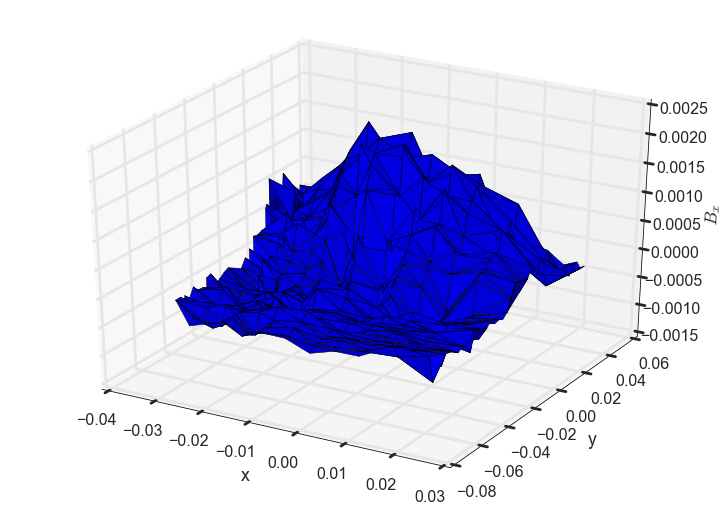

In [25]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points[0][:,0], points[0][:,1], values[0])
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel(r'$B_x$', labelpad=20)
plt.show()

In [9]:
values[0].shape

(540,)

In [4]:
def interpolate_plane(plane_to_interpolate, grid_points):

    bx_measurements = struc_3d.read_idl('bx')
    by_measurements = struc_3d.read_idl('by')
    bz_measurements = struc_3d.read_idl('bz')

    for plane in [0.249, 0.302, 0.357, 0.416]:
        bx_measurements[plane] = struc_3d.average_duplicate_points(bx_measurements[plane])
        by_measurements[plane] = struc_3d.average_duplicate_points(by_measurements[plane])
        bz_measurements[plane] = struc_3d.average_duplicate_points(bz_measurements[plane])

    direction_measurements = [bx_measurements, by_measurements, bz_measurements] 

    interpolated_vectors = []
    interpolators = []
    tri_interpolators = []
    for time_point in xrange(21):
        print time_point
        points = []
        values = []
        for measurements in direction_measurements:
            (points_direction,
             values_direction) = struc_3d.read_points_from_measurement_dict(measurements,
                                                                            time_point,
                                                                            [plane_to_interpolate])
            points.append(points_direction)
            values.append(values_direction)
    
        points[0] = np.delete(points[0], 2, axis=1)
        points[1] = np.delete(points[1], 2, axis=1)
        points[2] = np.delete(points[2], 2, axis=1)
        interpolated_vector = struc_3d.interpolate_vector(grid_points, points, values)
    
        assert np.sum(np.isnan(interpolated_vector[0])) == 0
        assert np.sum(np.isnan(interpolated_vector[1])) == 0
        assert np.sum(np.isnan(interpolated_vector[2])) == 0
    
        sizes = (np.unique(grid_points[:, 0]).size,
                 np.unique(grid_points[:, 1]).size)
    
        grid_swapped = np.swapaxes(grid_points, 0, 1)
        grid_x = np.resize(grid_swapped[0], (sizes[0], sizes[1]))
        grid_y = np.resize(grid_swapped[1], (sizes[0], sizes[1]))
        grid = np.asarray([grid_x, grid_y])
    
        interpolated_vector = np.asarray(interpolated_vector)
        vector_swapped = np.swapaxes(interpolated_vector, 0, 1)
        vector_x = np.resize(vector_swapped[:, 0], (sizes[0], sizes[1]))
        vector_y = np.resize(vector_swapped[:, 1], (sizes[0], sizes[1]))
        vector = np.asarray([vector_x, vector_y])
    
        interpolated_vectors.append(vector)
    
    
        interpolator_x = LinearNDInterpolator(points[0], values[0])
        interpolator_y = LinearNDInterpolator(points[1], values[1])
        interpolator_z = LinearNDInterpolator(points[2], values[2])
        
        interpolators.append([interpolator_x, 
                              interpolator_y, 
                              interpolator_z])
    
        delaunay_x = Delaunay(points[0])
        delaunay_y = Delaunay(points[1])
        delaunay_z = Delaunay(points[2])
    
        triangulation_x = tri.Triangulation(points[0][:, 0], 
                                            points[0][:, 1], 
                                            triangles=delaunay_x.simplices)
        triangulation_y = tri.Triangulation(points[1][:, 0], 
                                            points[1][:, 1], 
                                            triangles=delaunay_y.simplices)
        triangulation_z = tri.Triangulation(points[2][:, 0], 
                                            points[2][:, 1], 
                                            triangles=delaunay_z.simplices)
    
        tri_interpolator_x = tri.triinterpolate.TriInterpolator(triangulation_x, 
                                                                values[0])
        tri_interpolator_y = tri.triinterpolate.TriInterpolator(triangulation_y, 
                                                                values[1])
        tri_interpolator_z = tri.triinterpolate.TriInterpolator(triangulation_z, 
                                                                values[2])
        tri_interpolators.append([tri_interpolator_x, 
                                  tri_interpolator_y, 
                                  tri_interpolator_z])
        
    return interpolated_vectors, interpolators, tri_interpolators

In [54]:
interpolated_vectors_z0249, interpolators_z0249 = interpolate_plane(0.249, grid_points)[0:2]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [55]:
spatial_increment = 0.001
x_min, x_max = -0.022, 0.021
y_min, y_max = -0.038, 0.04
z_min, z_max = 0.302, 0.302

bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

x_coord = np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment))
y_coord = np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment))

mesh = np.meshgrid(x_coord, y_coord, indexing='ij')
grid_points = np.dstack(map(np.ravel, mesh))[0]

sizes = (np.unique(grid_points[:, 0]).size,
         np.unique(grid_points[:, 1]).size)
    
grid_swapped = np.swapaxes(grid_points, 0, 1)
grid_x = np.resize(grid_swapped[0], (sizes[0], sizes[1]))
grid_y = np.resize(grid_swapped[1], (sizes[0], sizes[1]))
grid_z0302 = np.asarray([grid_x, grid_y])

In [56]:
interpolated_vectors_z0302, interpolators_z0302 = interpolate_plane(0.302, grid_points)[0:2]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [57]:
spatial_increment = 0.001
x_min, x_max = -0.041, 0.030
y_min, y_max = -0.019, 0.0255
z_min, z_max = 0.357, 0.357

bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

x_coord = np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment))
y_coord = np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment))

mesh = np.meshgrid(x_coord, y_coord, indexing='ij')
grid_points = np.dstack(map(np.ravel, mesh))[0]

sizes = (np.unique(grid_points[:, 0]).size,
         np.unique(grid_points[:, 1]).size)
    
grid_swapped = np.swapaxes(grid_points, 0, 1)
grid_x = np.resize(grid_swapped[0], (sizes[0], sizes[1]))
grid_y = np.resize(grid_swapped[1], (sizes[0], sizes[1]))
grid_z0357 = np.asarray([grid_x, grid_y])

In [58]:
interpolated_vectors_z0357, interpolators_z0357 = interpolate_plane(0.357, grid_points)[0:2]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [59]:
spatial_increment = 0.001
x_min, x_max = -0.044, 0.031
y_min, y_max = -0.022, 0.027
z_min, z_max = 0.416, 0.416

bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

x_coord = np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment))
y_coord = np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment))

mesh = np.meshgrid(x_coord, y_coord, indexing='ij')
grid_points = np.dstack(map(np.ravel, mesh))[0]

sizes = (np.unique(grid_points[:, 0]).size,
         np.unique(grid_points[:, 1]).size)
    
grid_swapped = np.swapaxes(grid_points, 0, 1)
grid_x = np.resize(grid_swapped[0], (sizes[0], sizes[1]))
grid_y = np.resize(grid_swapped[1], (sizes[0], sizes[1]))
grid_z0416 = np.asarray([grid_x, grid_y])

In [60]:
interpolated_vectors_z0416, interpolators_z0416 = interpolate_plane(0.416, grid_points)[0:2]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [61]:
len(interpolators_z0416)

21

In [67]:
prefix = '../output/2016-08-06/'
z0249 = 'B_z_0249_'
z0302 = 'B_z_0302_'
z0357 = 'B_z_0357_'
z0416 = 'B_z_0416_'

points_ending = '.npz'
interpolator_ending = '.p'

for time_point in xrange(len(interpolated_vectors_z0249)):
    np.savez(prefix + z0249 +  str(time_point).zfill(4) + ending,
             b=interpolated_vectors_z0249, 
             grid=grid_z0249)
    
    np.savez(prefix + z0302 +  str(time_point).zfill(4) + ending,
             b=interpolated_vectors_z0302, 
             grid=grid_z0302)
    
    np.savez(prefix + z0357 +  str(time_point).zfill(4) + ending,
             b=interpolated_vectors_z0357, 
             grid=grid_z0357)
    
    np.savez(prefix + z0416 +  str(time_point).zfill(4) + ending,
             b=interpolated_vectors_z0416, 
             grid=grid_z0416)
    
    file_path = prefix + z0249
    pickle.dump(interpolators_z0249[time_point][0], open(file_path + 'x_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))
    pickle.dump(interpolators_z0249[time_point][1], open(file_path + 'y_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))
    pickle.dump(interpolators_z0249[time_point][2], open(file_path + 'z_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))
    
    file_path = prefix + z0302
    pickle.dump(interpolators_z0302[time_point][0], open(file_path + 'x_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))
    pickle.dump(interpolators_z0302[time_point][1], open(file_path + 'y_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))
    pickle.dump(interpolators_z0302[time_point][2], open(file_path + 'z_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))

    file_path = prefix + z0357
    pickle.dump(interpolators_z0357[time_point][0], open(file_path + 'x_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))
    pickle.dump(interpolators_z0357[time_point][1], open(file_path + 'y_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))
    pickle.dump(interpolators_z0357[time_point][2], open(file_path + 'z_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))

    file_path = prefix + z0416
    pickle.dump(interpolators_z0416[time_point][0], open(file_path + 'x_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))
    pickle.dump(interpolators_z0416[time_point][1], open(file_path + 'y_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))
    pickle.dump(interpolators_z0416[time_point][2], open(file_path + 'z_' + str(time_point).zfill(4) + interpolator_ending, 'wb'))